### Bond Fluctuation Model

Bond vector set: 
$B=P\pm\left(\begin{array}{c}
2\\
0\\
0
\end{array}\right)\bigcup P\pm\left(\begin{array}{c}
2\\
1\\
0
\end{array}\right)\bigcup P\pm\left(\begin{array}{c}
2\\
1\\
1
\end{array}\right)\bigcup P\pm\left(\begin{array}{c}
2\\
2\\
1
\end{array}\right)\bigcup P\pm\left(\begin{array}{c}
3\\
0\\
0
\end{array}\right)\bigcup P\pm\left(\begin{array}{c}
3\\
1\\
0
\end{array}\right)$

Lattice occupation: $\vec{r}
+\left(\begin{array}{c}1\\ 0\\ 0 \end{array}\right)
+\left(\begin{array}{c}0\\ 1\\ 0 \end{array}\right)
+\left(\begin{array}{c}0\\ 0\\ 1 \end{array}\right)
+\left(\begin{array}{c}1\\ 1\\ 0 \end{array}\right)
+\left(\begin{array}{c}1\\ 0\\ 1 \end{array}\right)
+\left(\begin{array}{c}0\\ 1\\ 1 \end{array}\right)
+\left(\begin{array}{c}1\\ 1\\ 1 \end{array}\right)$

In [1]:
%pylab notebook
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


In [61]:
class monomer:
    ''' monomer class with unique index, containing the coordinates, bondpartners and attributes of a single BFM monomer '''
    def __init__(self, idx_, coords_, attributes_, bonds_ = []):
        ''' setting properties of monomer:
        idx: unique index (int),
        coords: d-dimensional coordinates (np.array),
        attributes: dict of properties (python dict),
        bonds: list of neigbor indizees (np.array)'''
        self.idx = idx_
        self.coords = coords_
        self.attributes = attributes_
        self.bonds = bonds_
#


In [62]:
class validBonds:
    ''' class containing the bondset and utility to check if bonds are valid '''
    def __init__(self):
        self.allBonds = [( 2, 0, 0), (0,  2, 0), (0, 0,  2), # (2,0,0)
                         (-2, 0, 0), (0, -2, 0), (0, 0, -2),
                         (2, 1, 0), (2, 0, 1), (0, 2, 1), (0, 1, 2),(1, 2, 0),(1, 0, 2), # (2,1,0)
                         (-2, 1, 0), (-2, 0, 1), (0, -2, 1), (0, 1, -2),(1, -2, 0),(1, 0, -2),
                         (2, -1, 0), (2, 0, -1), (0, 2, -1), (0, -1, 2),(-1, 2, 0),(-1, 0, 2),
                         (-2, -1, 0), (-2, 0, -1), (0, -2, -1), (0, -1, -2),(-1, -2, 0),(-1, 0, -2),
                         ( 2, 1, 1), (1,  2, 1), (1, 1,  2), # (2,1,1)
                         ( -2, 1, 1), (-1,  2, 1), (-1, 1,  2),
                         ( 2, -1, 1), (1,  -2, 1), (1, -1,  2),
                         ( 2, 1, -1), (1,  2, -1), (1, 1,  -2),
                         ( -2, -1, 1), (-1,  -2, 1), (-1, -1,  2),
                         ( 2, -1, -1), (1,  -2, -1), (1, -1,  -2),
                         ( -2, 1, -1), (-1,  2, -1), (-1, 1,  -2),
                         ( -2, -1, -1), (-1,  -2, -1), (-1, -1,  -2),
                         (2, 2, 1), (2, 1, 2), (1, 2, 2), # (2,2,1)
                         (-2, 2, 1), (-2, 1, 2), (-1, 2, 2),
                         (2, -2, 1), (2, -1, 2), (1, -2, 2),
                         (2, 2, -1), (2, 1, -2), (1, 2, -2),
                         (-2, -2, 1), (-2, -1, 2), (-1, -2, 2),
                         (2, -2, -1), (2, -1, -2), (1, -2, -2),
                         (-2, 2, -1), (-2, 1, -2), (-1, 2, -2),
                         (-2, -2, -1), (-2, -1, -2), (-1, -2, -2),
                         ( 3, 0, 0), (0,  3, 0), (0, 0,  3), # (3,0,0)
                         (-3, 0, 0), (0, -3, 0), (0, 0, -3),
                         (3, 1, 0), (3, 0, 1), (0, 3, 1), (0, 1, 3),(1, 3, 0),(1, 0, 3), # (3,1,0)
                         (-3, 1, 0), (-3, 0, 1), (0, -3, 1), (0, 1, -3),(1, -3, 0),(1, 0, -3),
                         (3, -1, 0), (3, 0, -1), (0, 3, -1), (0, -1, 3),(-1, 3, 0),(-1, 0, 3),
                         (-3, -1, 0), (-3, 0, -1), (0, -3, -1), (0, -1, -3),(-1, -3, 0),(-1, 0, -3)
                        ]
        self.lookup = np.zeros((512))
        # setup lookup table without check
        for b in self.allBonds:
            idf = self.bondToIdentifier(b)
            self.lookup[idf]=1
        
    def bondToIdentifier(self, b):
        ''' return a unique hash for every bond to use the fast lookup table self.lookup '''
        return (b[0] & 7) + ((b[1] &7) << 3) + ((b[2] &7) << 6)
    
    def checkBondInSet(self, b):
        ''' return True if bond b is part of the valid bondset or False otherwise '''
        return self.lookup[(self.bondToIdentifier(b))]
    
#


In [106]:
class excludedVolumeLattice:
    ''' class providing a lookup lattice to implement excluded volume checks in BFM simulations '''
    def __init__(self, box_):
        ''' setup of zero valued lattice with sizes taken from the box'''
        self.boxX, self.boxY, self.boxZ = box_
        self.lattice = np.zeros((self.boxX,self.boxY,self.boxZ), dtype=np.uint8)
        
    def fold_back(self,x,y,z):
        ''' fold back function to account for periodic boundary conditions '''
        myX = (((x% self.boxX)+ self.boxX)% self.boxX)
        myY = (((y% self.boxY)+ self.boxY)% self.boxY)
        myZ = (((z% self.boxZ)+ self.boxZ)% self.boxZ)

        return myX, myY, myZ
    
    def setMonomer(self, x,y,z):
        ''' set the position of a monomer.
        Sanity Check: check if lattice positions are free before overwriting them
        '''
        if( (self.lattice[self.fold_back(x  ,y  ,z  )]
          + self.lattice[self.fold_back(x+1,y  ,z  )]
          + self.lattice[self.fold_back(x  ,y+1,z  )]
          + self.lattice[self.fold_back(x  ,y  ,z+1)]
          + self.lattice[self.fold_back(x+1,y+1,z  )]
          + self.lattice[self.fold_back(x+1,y  ,z+1)]
          + self.lattice[self.fold_back(x  ,y+1,z+1)]
          + self.lattice[self.fold_back(x+1,y+1,z+1)])
           != 0
          ):
            return False
            #raise ValueError("monomer position {} already occupied ".format([x,y,z]))
        else: 
            self.lattice[self.fold_back(x  ,y  ,z  )] = 1
            self.lattice[self.fold_back(x+1,y  ,z  )] = 1
            self.lattice[self.fold_back(x  ,y+1,z  )] = 1
            self.lattice[self.fold_back(x  ,y  ,z+1)] = 1
            self.lattice[self.fold_back(x+1,y+1,z  )] = 1
            self.lattice[self.fold_back(x+1,y  ,z+1)] = 1
            self.lattice[self.fold_back(x  ,y+1,z+1)] = 1
            self.lattice[self.fold_back(x+1,y+1,z+1)] = 1

            return True
        
    def clearMonomer(self, x, y, z):
        ''' remove the previous position of a monomer.
        Sanity Check: check if lattice positions are occupied before overwriting them
        '''
        if( (self.lattice[self.fold_back(x  ,y  ,z  )]
          + self.lattice[self.fold_back(x+1,y  ,z  )]
          + self.lattice[self.fold_back(x  ,y+1,z  )]
          + self.lattice[self.fold_back(x  ,y  ,z+1)]
          + self.lattice[self.fold_back(x+1,y+1,z  )]
          + self.lattice[self.fold_back(x+1,y  ,z+1)]
          + self.lattice[self.fold_back(x  ,y+1,z+1)]
          + self.lattice[self.fold_back(x+1,y+1,z+1)])
           != 8
          ):
            return False
            #raise ValueError("monomer position {} was not occupied ".format([x,y,z]))
        else:
            self.lattice[self.fold_back(x  ,y  ,z  )] = 0
            self.lattice[self.fold_back(x+1,y  ,z  )] = 0
            self.lattice[self.fold_back(x  ,y+1,z  )] = 0
            self.lattice[self.fold_back(x  ,y  ,z+1)] = 0
            self.lattice[self.fold_back(x+1,y+1,z  )] = 0
            self.lattice[self.fold_back(x+1,y  ,z+1)] = 0
            self.lattice[self.fold_back(x  ,y+1,z+1)] = 0
            self.lattice[self.fold_back(x+1,y+1,z+1)] = 0

            return True
        
    def syncLattice(self,molecules):
        ''' set lattice to zero again and apply the current lattice occupation from molecules '''
        # reset lattice
        self.lattice = np.zeros((self.boxX,self.boxY,self.boxZ), dtype=np.uint8)
        # refresh lattice occupation
        for m in molecules:
            self.setMonomer(m.coords[0],m.coords[1],m.coords[2])
        
    def checkLattice(self,newPos,move):
        ''' check if a new position of a BFM unit is free on the lattice
        by taking the coordinates of the new anchor and the move coordinates '''
        # shift position by one if move in positive direction to keep the cube
        refPos = 1*newPos
        if ( np.any((np.array(move) > 0)) ):
            refPos += move
            
        # get perpendicular directions to move direction
        #(1 0 0) or (0 1 0)
        perX1 = 1 if move[0]==0 else 0
        perY1 = 1 if move[0]!=0 else 0
        # (0 1 0) or (0 0 1)
        perY2 = 0 if move[2]==0 else 1
        perZ2 = 0 if move[2]!=0 else 1
        #print(move,(perX1,perY1,0),(0,perY2,perZ2))
        
        # check if lattice sites are free
        if(self.lattice[self.fold_back(refPos[0],refPos[1],refPos[2])] == 1):
            return False
        if(self.lattice[self.fold_back(refPos[0]+perX1,refPos[1]+perY1,refPos[2])] == 1):
            return False
        if(self.lattice[self.fold_back(refPos[0],refPos[1]+perY2,refPos[2]+perZ2)] == 1):
            return False
        if(self.lattice[self.fold_back(refPos[0]+perX1,refPos[1]+perY1+perY2,refPos[2]+perZ2)] == 1):
            return False
        
        # if they are free return true
        return True
    
    def moveOnLattice(self,oldPos,newPos):
        ''' update lattice by move: simply delete the old lattice sites and occupy the new ones '''
        if self.clearMonomer(oldPos[0],oldPos[1],oldPos[2]):
            self.setMonomer(newPos[0],newPos[1],newPos[2])
            return True
        else:
            return False

In [107]:
class BFMSimulator:
    ''' class providing utilities for 3D BFM simulations:
    monomer container, bondset, move and apply function '''
    def __init__(self, box_, periodicity_):
        ''' setting up simulation box:
        box = [boxX, boxY, boxZ] (python list of int),
        periodicity = [pX, pY, pZ] (python list of bools), True = is periodic, False = wall
        bondset (instance of class validBonds)
        ... and setup:
        empty molecules as empty list,
        empty lattice (boxX*boxY*boxZ) with 0 as initial value (np.array),
        list of moves (python list)'''
        self.boxX, self.boxY, self.boxZ = box_
        self.pX, self.pY, self.pZ = periodicity_
        self.bondset = validBonds()
        self.molecules = []
        self.lattice = excludedVolumeLattice([self.boxX, self.boxY, self.boxZ])
        self.moves = [(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]
        self.Nmoves = len(self.moves)
        self.setup = False
        
    def connectMonomers(self, idx1, idx2):
        ''' connect two monomers in molecules by index '''
        bond = (self.molecules[idx2].coords - self.molecules[idx1].coords)
        if ( self.bondset.checkBondInSet(bond) ):
            self.molecules[idx1].bonds.append(idx2)
            self.molecules[idx2].bonds.append(idx1)
        else:
            raise ValueError("bond between {} and {} is not valid: {}".format(idx1,idx2, bond))
        
    def addMonomer(self, coords, attributes):
        ''' add new monomer at the end of molecules '''
        newIdx = len(self.molecules)
        if not self.lattice.setMonomer(coords[0],coords[1],coords[2]):
            raise ValueError("Monomer {} could not be placed at ".format(newIdx,coords))
        self.molecules.append(monomer(newIdx ,coords, attributes,[]))
        
    def plotConfig(self):
        ''' plot all monomers using scatter and bonds using plot with the box as axis boundaries '''
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        colorList = ["green","red"]
        
        myX = np.array([x.coords[0] for x in self.molecules])
        myY = np.array([x.coords[1] for x in self.molecules])
        myZ = np.array([x.coords[2] for x in self.molecules])
        
        mX, mY, mZ = [np.array(()),np.array(()),np.array(())]
        for m in self.molecules:
            if (m.idx + 1) in m.bonds:
                mX = np.append(mX,myX[m.idx])
                mY = np.append(mY,myY[m.idx])
                mZ = np.append(mZ,myZ[m.idx])
            else:
                mX = np.append(mX,myX[m.idx])
                mY = np.append(mY,myY[m.idx])
                mZ = np.append(mZ,myZ[m.idx])
                ax.plot(mX,mY,mZ)
                mX, mY, mZ = [np.array(()),np.array(()),np.array(())]
            
        #ax.plot(myX,myY,myZ)
        
        myFixed = [x.attributes["fixed"] for x in self.molecules]
        myColors = [colorList[int(c)] for c in myFixed ]
        ax.scatter(myX,myY,myZ, c=myColors)
        
        ax.set_xlim3d(0, self.boxX)
        ax.set_ylim3d(0, self.boxY)
        ax.set_zlim3d(0, self.boxZ)
        
        fig.show()
    
    def checkMove(self, idx, direction):
        ''' apply the move checks for monomer with index idx:
        takes monomer id and key of move direction [0,self.Nmoves)
        check the attribute fixed,
        check new bonds, check lattice, check boundaries'''
        # check fixed monomer attribute
        if "fixed" in self.molecules[idx].attributes:
            if (self.molecules[idx].attributes["fixed"] == True):
                return False
            
        # get new position
        newPos = self.molecules[idx].coords + self.moves[direction]
        x, y, z = newPos
        
        # check boundaries: 
        if not self.pX:
            if x == 0 or x == (self.boxX-1):
                return False
        if not self.pY:
            if y == 0 or y == (self.boxY-1):
                return False
        if not self.pZ:
            if z == 0 or z == (self.boxZ-1):
                return False   
        
        # check bonds
        for neighbIdx in self.molecules[idx].bonds:
            bnd = (newPos - self.molecules[neighbIdx].coords)
            if not ( self.bondset.checkBondInSet(bnd) ):
                return False
        
        # check lattice occupation
        if not self.lattice.checkLattice(newPos,self.moves[direction]):
            return False
        
        # if still here, all checks have been passed
        return True
        
    def applyMove(self,idx,direction):
        ''' apply a move: set new coordinate in molecules and update the lattice '''
        oldPos = 1*self.molecules[idx].coords
        newPos = (self.molecules[idx].coords + self.moves[direction])
        
        if self.lattice.moveOnLattice(oldPos, newPos):
            self.molecules[idx].coords = (newPos)
        else:
            print("error in apply move: Monomer {} in direction {} from {} to {}".format(idx,direction,oldPos,newPos))
        
    def performMCS(self,time):
        ''' apply the BFM algorithm on a given system for 'time' Monte Carlo sweeps '''
        if self.setup == False:
            self.lattice.syncLattice(self.molecules)
        counter = 0
        mol_size = len(self.molecules)
        for t in range(time):
            for n in range(mol_size):
                randomIdx = random.randint(mol_size)
                randomDir = random.randint(self.Nmoves)
                if self.checkMove(randomIdx,randomDir):
                    self.applyMove(randomIdx,randomDir)
                    counter += 1
            #self.lattice.syncLattice(self.molecules)
        print("applied moves / attempted moves:\n{} / {} = {}".format(counter, time*mol_size, counter/(time*mol_size)))
        
    #
    def checkConfig(self):
        ''' sanity check of the full simulation system '''
        nErrors = 0
        for m in self.molecules:
            for bp in m.bonds:
                bv = m.coords - self.molecules[bp].coords
                if self.bondset.checkBondInSet(bv) == False:
                    print("bond between {} and {} not valid: {}".format(m.idx,self.molecules[bp].idx,bv))
                    nErrors += 1
            if not self.pX:
                if (m.coords[0] < 0) or (m.coords[0] > (self.boxX-1) ):
                    print("monomer {} violates the simulation box size".format(m.idx))
                    nErrors += 1
            if not self.pY:
                if (m.coords[1] < 0) or (m.coords[1] > (self.boxY-1) ):
                    print("monomer {} violates the simulation box size".format(m.idx))
                    nErrors += 1
            if not self.pZ:
                if (m.coords[2] < 0) or (m.coords[2] > (self.boxZ-1) ):
                    print("monomer {} violates the simulation box size".format(m.idx))
                    nErrors += 1
                    
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0],m.coords[1],m.coords[2])] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0],m.coords[1],m.coords[2])))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0]+1,m.coords[1],m.coords[2])] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0]+1,m.coords[1],m.coords[2])))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0],m.coords[1]+1,m.coords[2])] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0],m.coords[1]+1,m.coords[2])))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0],m.coords[1],m.coords[2]+1)] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0],m.coords[1],m.coords[2]+1)))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0]+1,m.coords[1]+1,m.coords[2])] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0]+1,m.coords[1]+1,m.coords[2])))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0]+1,m.coords[1],m.coords[2]+1)] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0]+1,m.coords[1],m.coords[2]+1)))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0],m.coords[1]+1,m.coords[2]+1)] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0],m.coords[1]+1,m.coords[2]+1)))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0]+1,m.coords[1]+1,m.coords[2]+1)] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0]+1,m.coords[1]+1,m.coords[2]+1)))
                nErrors += 1
                
        if self.lattice.lattice.sum() != (len(self.molecules)*8):
            print("total lattice occupation is inconsistent {}/{}".format(self.lattice.lattice.sum(), len(self.molecules)*8))
            nErrors += 1
            
        return nErrors
#

<IPython.core.display.Javascript object>


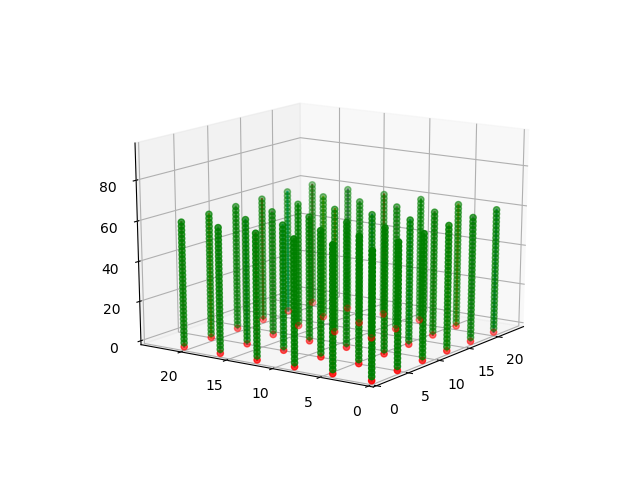

applied moves / attempted moves:
264355 / 1152000 = 0.2294748263888889


<IPython.core.display.Javascript object>


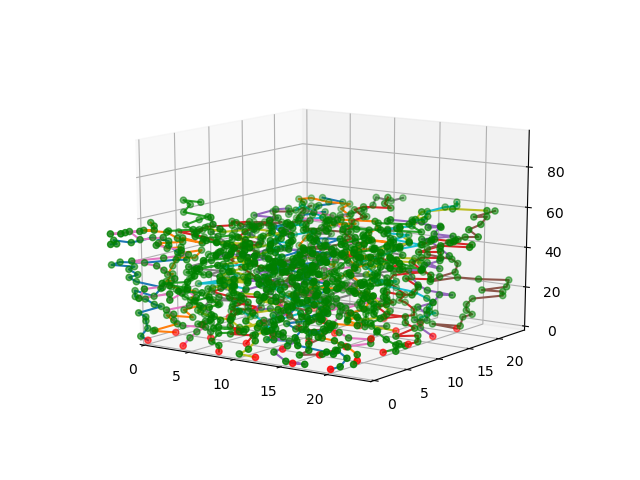

In [112]:
# Spielen mit Attributen und Parametern: Polymerbürste

# grafting densities 1/9, 1/16, 1/25
sigmaInv = 16
# Kettenlängen 32, ?
N = 32
# ketten array csp = 8x8 ? -> dauert ganz schön lange... besser 6x6?
nChainsPerDirection = 6

# ab hier wird alles aus den obigen Parametern berechnet:
'''----------------------------------------------------------'''
distanceInXYDirection = int(np.sqrt(sigmaInv))
distanceInZ = 2
myBoxXY = nChainsPerDirection*distanceInDirection

# setup Simulator
hugo = BFMSimulator( [myBoxXY,myBoxXY,N*3], [True, True, False] )

for dx in range(nChainsPerDirection):
    for dy in range(nChainsPerDirection):
        for z in range(N):
            coords = np.array([dx*distanceInXYDirection,dy*distanceInXYDirection,z*distanceInZ])
            if (z==0):
                attr = {"fixed": True}
            else:
                attr = {"fixed": False}
            hugo.addMonomer(coords,attr)
            if not z==0:
                hugo.connectMonomers(len(hugo.molecules)-2,len(hugo.molecules)-1)

# check config after creation
hugo.lattice.syncLattice(hugo.molecules)
hugo.checkConfig()
hugo.plotConfig()
#print(hugo.lattice.lattice)

# check config after some steps
hugo.performMCS(1000)
hugo.checkConfig()
hugo.plotConfig()
#print(hugo.lattice.lattice)

In [ ]:
# lineare Kette, Rg, Re, ...
N = 32
box = 64

chainSim = BFMSimulator( [box,box,box], [True, True, True] )